In [ ]:
'''
Dataset: https://www.kaggle.com/ardamavi/sign-language-digits-dataset

'''

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/X.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/X.npy


In [65]:
# notebook imports

import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import PIL
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

In [5]:
dir_path = r'/kaggle/input/sign-language-digits-dataset'
classes = ['0','1','2','3','4','5','6','7','8','9']

In [13]:
# data loading

data = np.load(os.path.join(dir_path,'X.npy'))
target = np.load(os.path.join(dir_path,'Y.npy'))

Y = np.zeros(data.shape[0])

# correcting wrongly matched data (refer: https://www.kaggle.com/ankitjha/practical-deep-learning-using-pytorch)

Y[:204] = 9
Y[204:409] = 0
Y[409:615] = 7
Y[615:822] = 6
Y[822:1028] = 1
Y[1028:1236] = 8
Y[1236:1443] = 4
Y[1443:1649] = 3
Y[1649:1855] = 2
Y[1855:] = 5

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size = .02, random_state = 2)


In [14]:
X_train.shape, y_train.shape

((2020, 64, 64), (2020,))

In [53]:
# pytorch imports

import torch 
from torch import Tensor

import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable

from torch.optim import lr_scheduler
from torch.optim import SGD

from torch.nn import Sequential,Conv2d,MaxPool2d,BatchNorm2d,Flatten,ReLU
from torch.nn import Module, Sigmoid, Linear, ReLU, Softmax
from torch.nn.init import kaiming_uniform_, xavier_uniform_
from torch.nn import CrossEntropyLoss, BCELoss

from torch.utils.data import Dataset, random_split, DataLoader

import torchvision
from torchvision import datasets,transforms,models

from sklearn import metrics
import itertools

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [54]:
# utility class for preprocessing data

class DatasetProcessing(Dataset):
    
    '''
    The Dataloader reads the data and puts it into memory
    '''
    
    #initialise the class variables - transform, data, target
    def __init__(self, data, target, transform=None): 
        self.transform = transform
        self.data = data.reshape((-1,64,64)).astype(np.float32)[:,:,:,None]
        # converting target to torch.LongTensor dtype
        self.target = torch.from_numpy(target).long() 
    
    '''
    Data must be wrapped on a Dataset parent class where 
    the methods getitem and len must be overrided. 
    Note that, the data is not loaded on memory by now.
    '''
    
    #retrieve the X and y index value and return it
    def __getitem__(self, index): 
        return self.transform(self.data[index]), self.target[index]
    
    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))

In [55]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

# preprocessing train data

data_train = DatasetProcessing(X_train,y_train,transform)

train_loader = torch.utils.data.DataLoader(data_train,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)

# preprocessing test data

data_test = DatasetProcessing(X_test,y_test,transform)

test_loader = torch.utils.data.DataLoader(data_test,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)


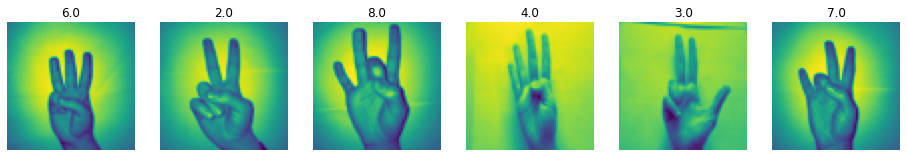

In [56]:
# plot some images of dataset

plt.figure(figsize = (16, 4))
for num, x in enumerate(X_train[0:6]):
    plt.subplot(1,6,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(y_train[num])

In [57]:
# class inheriting nn.Module for NeuralNets

class Net(nn.Module):    
    
    # This constructor will initialize the model architecture
    def __init__(self):
        super(Net, self).__init__()
          
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            # Putting a 2D Batchnorm after CNN layer
            nn.BatchNorm2d(32),
            # Adding Relu Activation
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
          
        self.linear_layers = nn.Sequential(
            # Adding Dropout
            nn.Dropout(p = 0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
        
    # Defining the forward pass    
    def forward(self, x):
        
        # Forward Pass through the CNN Layers 
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        # Forwrd pass through Fully Connected Layers
        x = self.linear_layers(x)
        return nn.functional.log_softmax(x) 

In [58]:
# utility function to train a model per epoch

def model_train(model,criterion,optimizer,scheduler,epoch):
    model.train()
    scheduler.step()
    tr_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        # Clearing the Gradients of the model parameters
        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output.data, 1)[1]
        correct += (pred == target).sum()
        total += len(data)
        
        # Computing the loss
        loss = criterion(output, target)
        
        # Computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        if (batch_idx + 1)% 100 == 0:
            print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Accuracy: {} %'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(),100 * correct / total))
            torch.save(model.state_dict(), './model.pth')
            torch.save(model.state_dict(), './optimizer.pth')
    train_loss.append(tr_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    
    return model

In [59]:
# utility function to evaluate model

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += nn.functional.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)
        correct += (pred == target).sum()
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

In [60]:
# utility function to plot graph

def plot_graph(epochs):
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Train - Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Train - Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , train_accuracy, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_accuracy, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

In [61]:
# defining the model

# model = nn.Sequential()

# model.add_module("conv1",nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1))
# model.add_module("poo1",nn.MaxPool2d(stride=2,kernel_size=2))

# model.add_module("conv2",nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1))
# model.add_module("pool2",nn.MaxPool2d(stride=2,kernel_size=2))

# model.add_module("conv3",nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1))
# model.add_module("pool3",nn.MaxPool2d(stride=2,kernel_size=2))

# model.add_module("flatten",nn.Flatten())

# model.add_module("dense1",nn.Linear(32*32*32,256))
# model.add_module("relu1",nn.ReLU(inplace=True))

# model.add_module("dense2",nn.Linear(256,256))
# model.add_module("relu2",nn.ReLU(inplace=True))

# model.add_module("output",nn.Linear(256,10))


In [62]:
# defining model, criterion,scheduler and optimizer

model = Net()

optimizer = optim.Adam(model.parameters(),lr=0.01)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [63]:
# train the model

num_epochs = 50

train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

for epoch in range(num_epochs):
    model = model_train(model,criterion,optimizer,exp_lr_scheduler,epoch)
    evaluate(test_loader)

Training Epoch: 0 [400/2020 (20%)]	Loss: 2.727598 	 Accuracy: 26.75 %
Training Epoch: 0 [800/2020 (40%)]	Loss: 0.560636 	 Accuracy: 35.5 %
Training Epoch: 0 [1200/2020 (59%)]	Loss: 2.749763 	 Accuracy: 38.0 %
Training Epoch: 0 [1600/2020 (79%)]	Loss: 1.109496 	 Accuracy: 40.3125 %
Training Epoch: 0 [2000/2020 (99%)]	Loss: 1.040744 	 Accuracy: 41.500003814697266 %

Average Validation loss: 3.79092	Accuracy: 42.85714340209961 %
Training Epoch: 1 [400/2020 (20%)]	Loss: 0.487080 	 Accuracy: 56.75 %
Training Epoch: 1 [800/2020 (40%)]	Loss: 2.802958 	 Accuracy: 60.0 %
Training Epoch: 1 [1200/2020 (59%)]	Loss: 0.930762 	 Accuracy: 59.91666793823242 %
Training Epoch: 1 [1600/2020 (79%)]	Loss: 2.553286 	 Accuracy: 58.25 %
Training Epoch: 1 [2000/2020 (99%)]	Loss: 1.126795 	 Accuracy: 58.45000457763672 %

Average Validation loss: 0.69857	Accuracy: 64.28571319580078 %
Training Epoch: 2 [400/2020 (20%)]	Loss: 0.582358 	 Accuracy: 65.0 %
Training Epoch: 2 [800/2020 (40%)]	Loss: 0.577810 	 Accuracy:

Training Epoch: 18 [2000/2020 (99%)]	Loss: 0.132439 	 Accuracy: 80.75000762939453 %

Average Validation loss: 0.15602	Accuracy: 95.23809814453125 %
Training Epoch: 19 [400/2020 (20%)]	Loss: 0.506669 	 Accuracy: 81.0 %
Training Epoch: 19 [800/2020 (40%)]	Loss: 0.900207 	 Accuracy: 79.25 %
Training Epoch: 19 [1200/2020 (59%)]	Loss: 0.188495 	 Accuracy: 80.58333587646484 %
Training Epoch: 19 [1600/2020 (79%)]	Loss: 1.147369 	 Accuracy: 80.0 %
Training Epoch: 19 [2000/2020 (99%)]	Loss: 0.102373 	 Accuracy: 80.4000015258789 %

Average Validation loss: 0.14886	Accuracy: 97.61904907226562 %
Training Epoch: 20 [400/2020 (20%)]	Loss: 0.029541 	 Accuracy: 84.5 %
Training Epoch: 20 [800/2020 (40%)]	Loss: 0.899534 	 Accuracy: 80.625 %
Training Epoch: 20 [1200/2020 (59%)]	Loss: 0.740443 	 Accuracy: 80.08333587646484 %
Training Epoch: 20 [1600/2020 (79%)]	Loss: 0.024087 	 Accuracy: 80.875 %
Training Epoch: 20 [2000/2020 (99%)]	Loss: 0.887116 	 Accuracy: 80.85000610351562 %

Average Validation loss: 

Training Epoch: 37 [1600/2020 (79%)]	Loss: 0.158507 	 Accuracy: 80.8125 %
Training Epoch: 37 [2000/2020 (99%)]	Loss: 0.165209 	 Accuracy: 80.9000015258789 %

Average Validation loss: 0.16197	Accuracy: 100.0 %
Training Epoch: 38 [400/2020 (20%)]	Loss: 0.120355 	 Accuracy: 81.25 %
Training Epoch: 38 [800/2020 (40%)]	Loss: 0.158142 	 Accuracy: 80.0 %
Training Epoch: 38 [1200/2020 (59%)]	Loss: 0.584167 	 Accuracy: 79.75 %
Training Epoch: 38 [1600/2020 (79%)]	Loss: 0.583747 	 Accuracy: 80.5 %
Training Epoch: 38 [2000/2020 (99%)]	Loss: 0.214550 	 Accuracy: 79.9000015258789 %

Average Validation loss: 0.16013	Accuracy: 97.61904907226562 %
Training Epoch: 39 [400/2020 (20%)]	Loss: 0.790417 	 Accuracy: 82.25 %
Training Epoch: 39 [800/2020 (40%)]	Loss: 1.128506 	 Accuracy: 81.5 %
Training Epoch: 39 [1200/2020 (59%)]	Loss: 0.468537 	 Accuracy: 80.91667175292969 %
Training Epoch: 39 [1600/2020 (79%)]	Loss: 0.254796 	 Accuracy: 81.1875 %
Training Epoch: 39 [2000/2020 (99%)]	Loss: 0.407637 	 Accurac

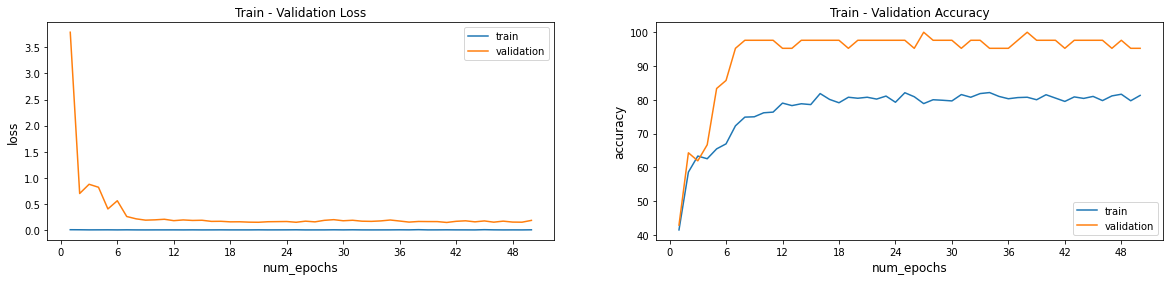

In [66]:
plot_graph(num_epochs)

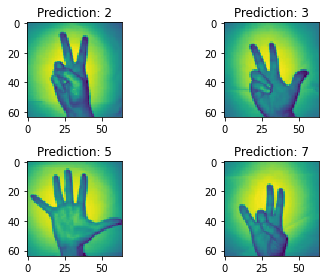

In [72]:
_, (validation_data, target) = next(enumerate(test_loader))
with torch.no_grad():
    output = model(validation_data.cuda())
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(validation_data[i][0], interpolation='none')
    pred = output.data.max(1, keepdim=True)[1][i].item()
    plt.title("Prediction: {}".format(pred))